## Imports

In [1]:
from model import *
from utils import *

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from scipy import signal

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb



from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import  Input


##   Loading  Data

In [2]:
num_subj = 8
num_timesteps = 20
loaded_data,load_labels = load_data(subject_count=num_subj)

Subject 8: 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]


In [3]:
loaded_data[0].head()

,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,FC2,...,P7,P3,Pz,P4,P8,PO9,O1,Oz,O2,PO10
0,-31,363,211,121,211,15,717,279,35,158,...,536,348,383,105,607,289,459,173,120,704
1,-29,342,216,123,222,200,595,329,43,166,...,529,327,369,78,613,248,409,141,83,737
2,-172,278,105,93,222,511,471,280,12,177,...,511,319,355,66,606,320,440,141,62,677
3,-272,263,-52,99,208,511,428,261,27,180,...,521,336,356,71,568,339,437,139,58,592
4,-265,213,-67,99,155,380,476,353,32,165,...,550,324,346,76,547,343,446,171,67,581


In [4]:
load_labels[0].head()

,HandStart,FirstDigitTouch,BothStartLoadPhase,LiftOff,Replace,BothReleased
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


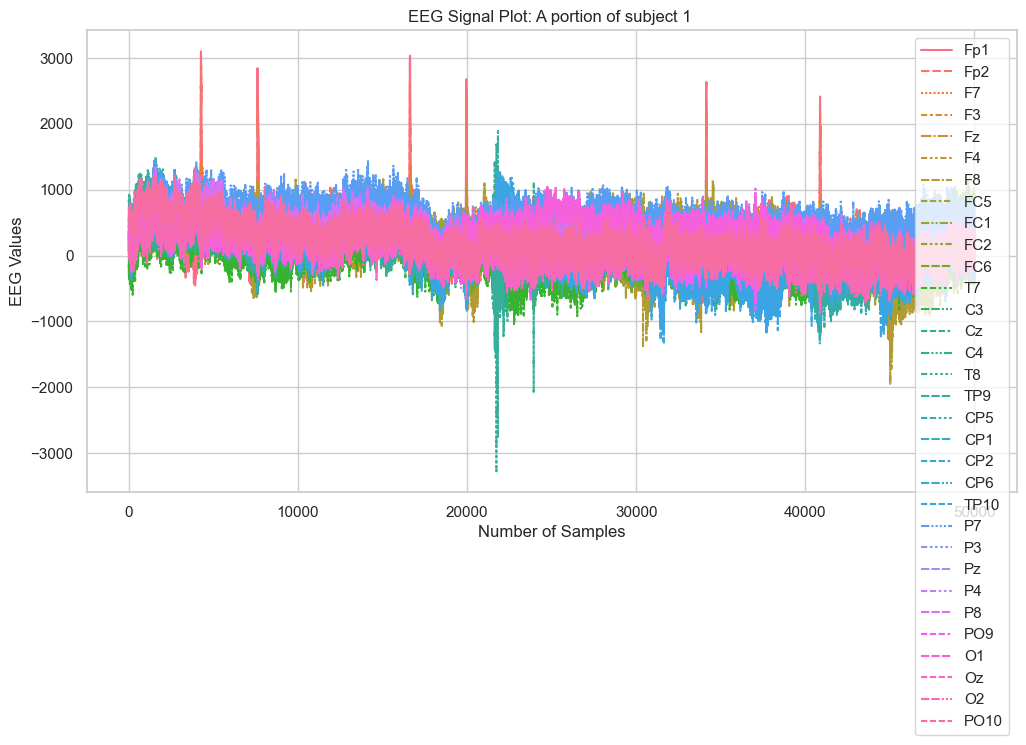

In [5]:
plot_eeg_signal(loaded_data[0],"A portion of subject 1 ")

## Data preprocessing

### Data Filtering with Butterworth Filter

 1. Filter Configuration: Sets up parameters for the Butterworth filter, including the alpha band, sampling rate, filter order, and Nyquist frequency.

2. Data Filtering: Applies the Butterworth filter to the loaded data, filtering each channel/column.

3. Data Storage: Stores the filtered data in a dictionary for further analysis or visualization.



In [6]:
alpha_band = [1, 30]
sampling_rate = 500
nyquist_freq = 0.5 * sampling_rate
low = alpha_band[0] / nyquist_freq
high = alpha_band[1] / nyquist_freq
order = 4


filtered_data_dic = {}
for i in range(len(loaded_data)):
    df = pd.DataFrame()
    for j in loaded_data[0].columns:

        data_subj = loaded_data[i][f"{j}"]
        b, a = signal.butter(order, [low, high], btype='band')
        filtered_data_subject = signal.filtfilt(b, a, data_subj)
        df[f"{j}"] = filtered_data_subject
    filtered_data_dic[f"{i}"] = df

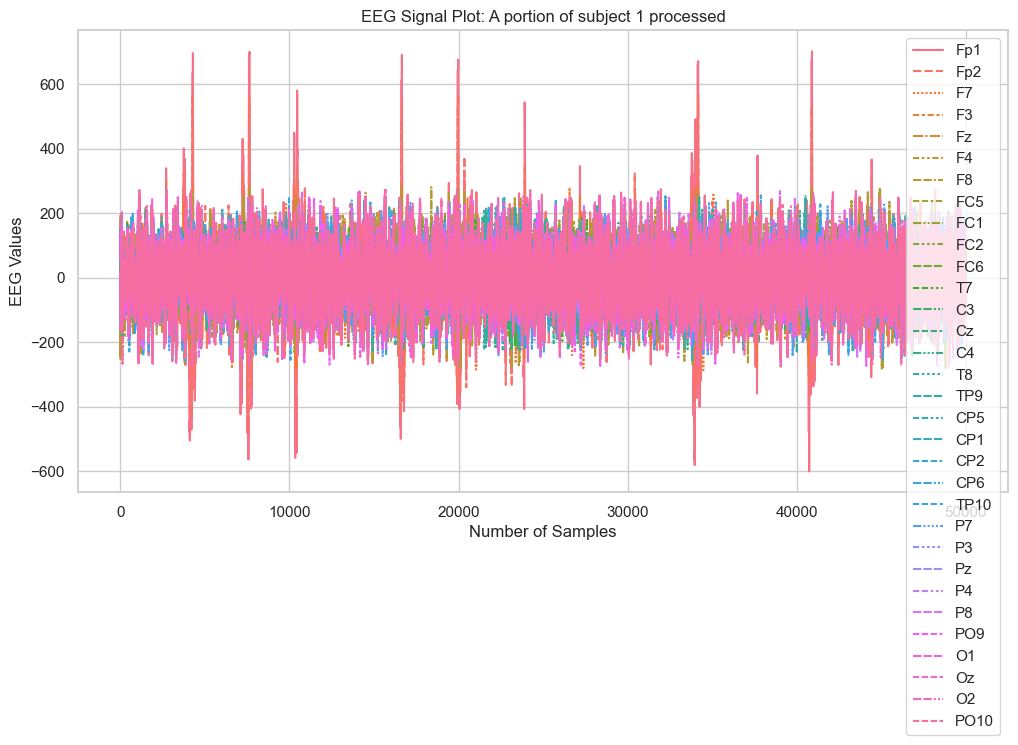

In [7]:
#Removing outliers from data using the Z-Score method.
procssed_data = {}
for idx,data in enumerate(filtered_data_dic.values()):
    procssed_data[idx] = remove_outliers_zscore(data,z_threshold = 3)
plot_eeg_signal(procssed_data[0],"A portion of subject 1 processed")


### Data Extraction

1. Label Processing: Processes loaded labels for analysis.

2. Data Extraction: Identifies and extracts data for each class based on processed labels.

3. Data Transformation: Processes the extracted data for further use.



In [8]:
processed_labels = process_load_labels(load_labels,num_subj)

beg_end = []
for data in processed_labels:
    val = start_end_data_finder(data)
    beg_end.append(val)

start_end_data = process_start_end(start_end = beg_end, threshold=num_timesteps)
all_extracted_data = []
for i in range(len(start_end_data)):
    extracted_data = data_extractor(start_end_data[i],filtered_data_dic[f"{i}"])
    all_extracted_data.append(extracted_data)

In [9]:
class_data, summed_data = calculate_class_data(all_extracted_data)
combined_dict = calculate_combined_dict(class_data)
print_class_summary(combined_dict)
min_length = calculate_min_length(summed_data)
print(f"Minimum Length: {min_length}")

Class 0: Data points = 2080
Class 1: Data points = 1845
Class 2: Data points = 1174
Class 3: Data points = 2067
Class 4: Data points = 1831
Class 5: Data points = 1831
Minimum Length: 1174


### Data Preparation

This notebook section demonstrates data preparation steps in Python. The code performs the following tasks:

1. Data Extraction: Extracts data with no events and stores it in `no_events_data_extracted`.

2. Class Labeling: Assigns class labels to the data.

3. Data Selection and Validation: Selects and validates data for analysis.

4. Data Transformation: Converts and reshapes the data for modeling.

5. Label Adjustment: Ensures label alignment with the data.


In [10]:
no_events_data_extracted = []
for idx, subj_data in enumerate(loaded_data):
    no_event = data_extractor_noevent(subj_data, load_labels[idx], min_length//8,threshold = num_timesteps)
    no_events_data_extracted.append(no_event)

In [11]:
##Creating labels for Processed Data

class_labels = np.ones(min_length*6)

for i in range(6):
    class_labels[i*min_length:(i+1)*min_length] = class_labels[i*min_length:(i+1)*min_length] *(i)

noevent_label = np.ones(min_length)*(6)

all_class_labels = np.concatenate((class_labels,noevent_label))

In [12]:
selected_data = []
for class_data in summed_data:
    selected_data.extend(class_data[:min_length+1])

for arr in no_events_data_extracted:
    selected_data.extend(arr)

for i in range(len(selected_data)):    
    if len(selected_data[i]) != num_timesteps+1:
        print(len(selected_data[i]))

selected_data = np.array(selected_data)
selected_data = np.reshape(np.array(selected_data),(selected_data.shape[0],selected_data.shape[1]*selected_data.shape[2]))

all_class_labels = all_class_labels[:selected_data.shape[0]]

print("selected_data shape:", selected_data.shape)
print("labels shape:", all_class_labels.shape)
print("selected_data data type:", selected_data.dtype)
print("labels data type:", all_class_labels.dtype)

selected_data shape: (8217, 672)
labels shape: (8217,)
selected_data data type: float64
labels data type: float64


### Scaling and Shuffling

In [13]:
all_data_shuffled , all_labels_shuffled = shuffle(selected_data, all_class_labels, random_state = 0)


ss = StandardScaler()
all_data_shuffled_scaled = ss.fit_transform(all_data_shuffled)


### Dimentionality reduction

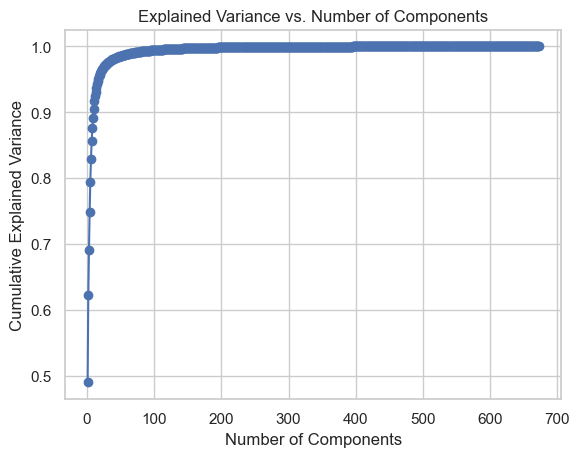

In [14]:

pca = PCA()

pca.fit(all_data_shuffled_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()


In [15]:
n_components = 60
pca = PCA(n_components = n_components)
pca.fit(all_data_shuffled)
pca_tr = pca.fit_transform(all_data_shuffled_scaled)

## Model Analysis

#### Support Vector machines

Accuracy: 0.3150851581508516


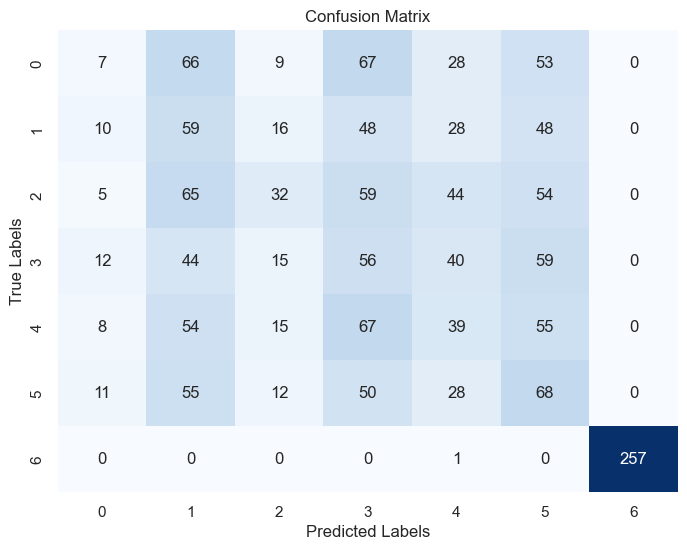

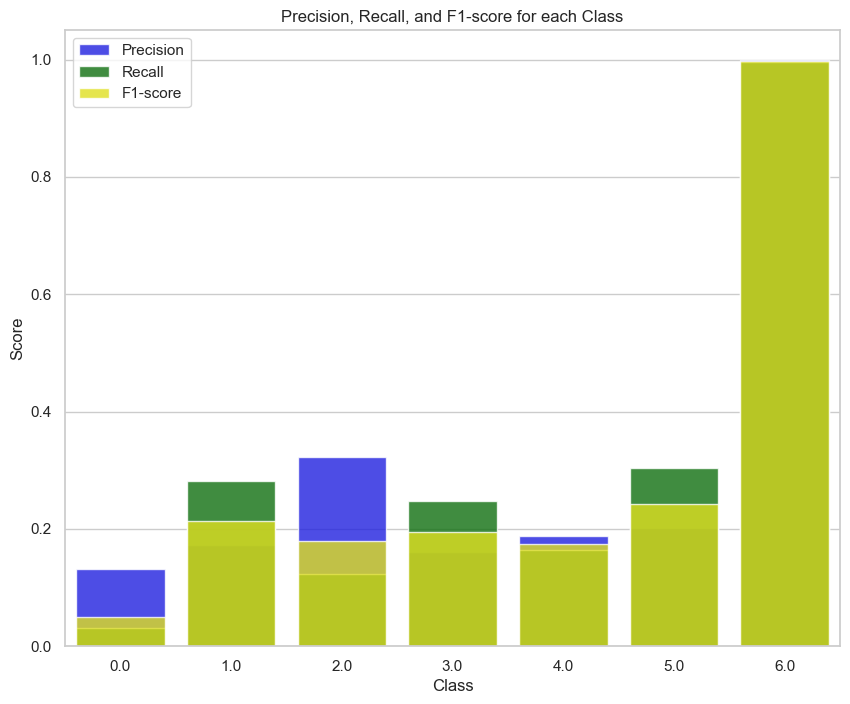

Classification Report:
              precision    recall  f1-score   support

         0.0       0.13      0.03      0.05       230
         1.0       0.17      0.28      0.21       209
         2.0       0.32      0.12      0.18       259
         3.0       0.16      0.25      0.20       226
         4.0       0.19      0.16      0.17       238
         5.0       0.20      0.30      0.24       224
         6.0       1.00      1.00      1.00       258

    accuracy                           0.32      1644
   macro avg       0.31      0.31      0.29      1644
weighted avg       0.33      0.32      0.30      1644



In [16]:

model = SVC(kernel="rbf")
evaluate_model(model, pca_tr,  all_labels_shuffled)

#### Random Forest Model


In [24]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],        # Number of trees in the forest
    'criterion': ['gini', 'entropy'],     # Splitting criterion
    'max_depth': [None, 10, 20],          # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],     # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],       # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt'],             # Specify 'sqrt' explicitly to avoid the warning
    'bootstrap': [True, False],           # Whether bootstrap samples are used when building trees
    'random_state': [42]                 # Random seed for reproducibility
}
model = RandomForestClassifier()
best_parameters = grid_search_cv(model, pca_tr, all_labels_shuffled,param_grid_rf)

model = RandomForestClassifier(**best_parameters)
evaluate_model(model, pca_tr, all_labels_shuffled)

Total parameter combinations to test: 8
Testing parameter combination 1 of 8: n_estimators


KeyboardInterrupt: 

#### K nearest neighbor
**n_neighbors** : A common heuristic is to use the square root of the number of data points in the dataset as the k-value. fo this case k=√3000 ≈ 54.

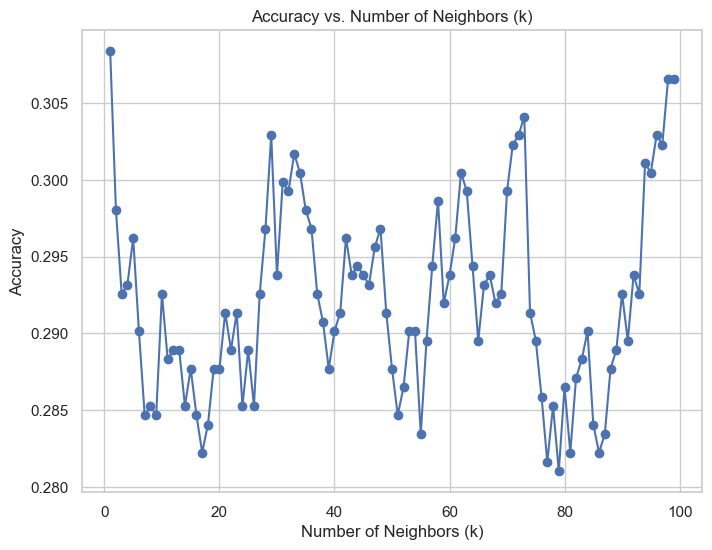

In [18]:
evaluate_knn_classifier(pca_tr, all_labels_shuffled)

Best Hyperparameters: {'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
Accuracy: 0.29257907542579076


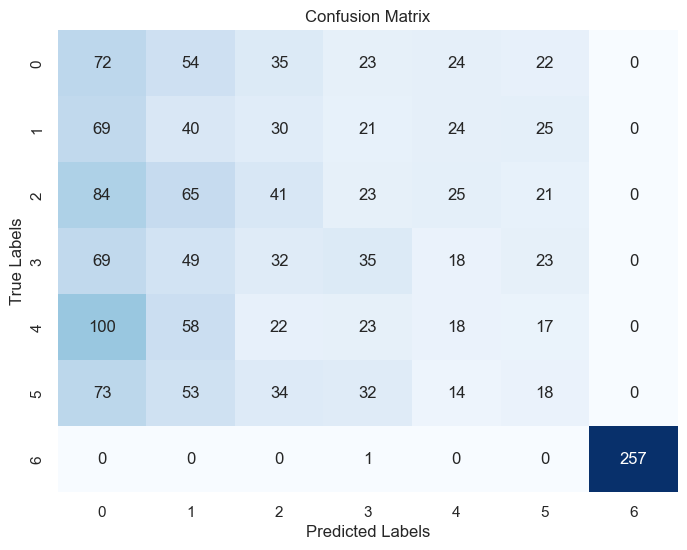

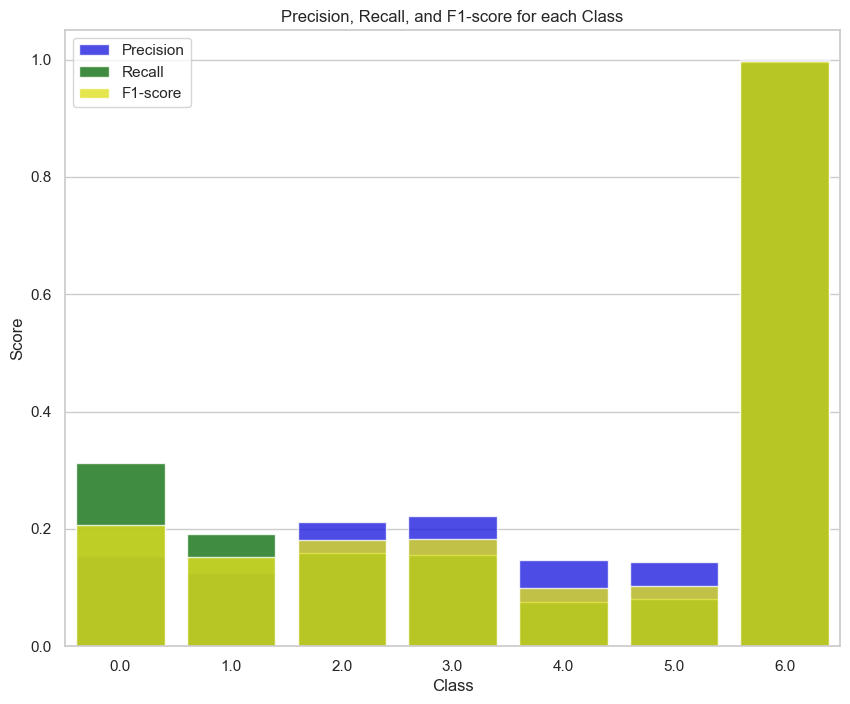

Classification Report:
              precision    recall  f1-score   support

         0.0       0.15      0.31      0.21       230
         1.0       0.13      0.19      0.15       209
         2.0       0.21      0.16      0.18       259
         3.0       0.22      0.15      0.18       226
         4.0       0.15      0.08      0.10       238
         5.0       0.14      0.08      0.10       224
         6.0       1.00      1.00      1.00       258

    accuracy                           0.29      1644
   macro avg       0.29      0.28      0.27      1644
weighted avg       0.30      0.29      0.29      1644



In [20]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}
model = KNeighborsClassifier()
best_parameters = grid_search_cv(model, pca_tr, all_labels_shuffled,param_grid)

model = KNeighborsClassifier(**best_parameters)
evaluate_model(model, pca_tr, all_labels_shuffled)

#### XGBoost

In [22]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import numpy as np

def grid_search_cv(model, data: np.array, labels: np.array, param_grid: dict):
    """
    Evaluate the performance of a given machine learning model on a dataset with hyperparameter tuning.

    Args:
        model (estimator): The machine learning model to evaluate.
        data (array-like): The input data for evaluation.
        labels (array-like): The corresponding labels for the input data.
        param_grid (dict): The hyperparameter grid for GridSearchCV.

    Returns:
        None
    """
    labels = np.ravel(labels)
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')

    total_combinations = len(grid_search.param_grid)
    print(f"Total parameter combinations to test: {total_combinations}")

    best_accuracy = 0.0
    best_params = None

    for i, params in enumerate(grid_search.param_grid):
        print(f"Testing parameter combination {i + 1} of {total_combinations}: {params}")
        grid_search.fit(X_train, y_train)
        current_accuracy = grid_search.best_score_
        if current_accuracy > best_accuracy:
            best_accuracy = current_accuracy
            best_params = grid_search.best_params_
            print(f"New best accuracy found: {best_accuracy:.4f}")
            print(f"Best hyperparameters so far: {best_params}")

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print("Final Best Hyperparameters:", best_params)
    print(f"Accuracy on the test set with best hyperparameters: {accuracy:.4f}")

    return best_params

# Example usage
# Define your model, data, and param_grid
# best_params = grid_search_cv(your_model, your_data, your_labels, your_param_grid)


In [21]:

param_grid = {
    'objective': ['multi:softmax'],  # Multi-class classification objective
    'num_class': [7],               # Number of classes in the multi-class problem
    'eval_metric': ['mlogloss'],    # Multiclass Logarithmic Loss
    'eta': [0.1, 0.2, 0.3],         # Learning rate
    'max_depth': [3, 4, 5],         # Maximum depth of a tree
    'subsample': [0.7, 0.8, 0.9],   # Subsample ratio of the training instances
    'colsample_bytree': [0.7, 0.8, 0.9],  # Subsample ratio of columns when constructing each tree
    'seed': [42]               # Random seed for reproducibility
}

model = xgb.XGBClassifier()
best_parameters = grid_search_cv(model, pca_tr, all_labels_shuffled,param_grid)

xgb_model = xgb.XGBClassifier(**best_parameters)
evaluate_model(xgb_model, pca_tr, all_labels_shuffled)






KeyboardInterrupt: 

### One-Hot Encoding


In [30]:
encoder = OneHotEncoder(sparse_output=False)

all_labels_shuffled = np.array(all_labels_shuffled).reshape(-1, 1)

one_hot_labels = encoder.fit_transform(all_labels_shuffled)



# Deep Learning Models


In [28]:
num_datapoint = all_data_shuffled_scaled.shape[0]
deep_learning_data = np.reshape(all_data_shuffled_scaled,(num_datapoint,num_timesteps+1,32))

## CNN

we will build a deep learning model using TensorFlow and Keras for multiclass classification.

In [31]:
n_channels = deep_learning_data.shape[1]
n_timepoints = deep_learning_data.shape[2]
input_shape=(n_channels, n_timepoints)


cnn_model = Sequential()
cnn_model.add(Conv1D(128, kernel_size=3, activation='relu',input_shape=input_shape ))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Conv1D(64, kernel_size=3, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Conv1D(128, kernel_size=3, activation='relu' ))
cnn_model.add(MaxPooling1D(pool_size=1))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Flatten())
cnn_model.add(Dense(32, activation='relu'))
cnn_model.add(Flatten())
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(7, activation='softmax'))

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

X_train, X_test, y_train, y_test = train_test_split(deep_learning_data, one_hot_labels, test_size=0.2, random_state=42)
cnn_model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 19, 128)           12416     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 9, 128)            0         
 g1D)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, 7, 64)             24640     
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 3, 64)             0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 1, 128)            24704     
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 1, 128)           



Interpretation:

The overall accuracy of the model is relatively low, but this is not unexpected given the complexity of the task. The model is able to classify the data points with perfect accuracy for class 6, but its performance on the other classes is not as good.

One possible explanation for the low accuracy is that the dataset is too small. With a larger dataset, the model would be able to learn the features of the data points more effectively and thus achieve higher accuracy.


Another possible explanation is that the model is overfitting the training data. This means that the model is learning the specific details of the training data too well, and it is not able to generalize to new data. To mitigate overfitting, we can use regularization techniques such as data augmentation and dropout.

Conclusion

This is a simple CNN model that can be used as a starting point for more complex models. The model can be improved by using a larger dataset and regularization techniques as well as using feature engineering techniques to allowfor better undrestanding of the eeg signals.

## ResNet


In [ ]:


num_classes = 7




resnet_model = create_resnet(input_shape = input_shape)


combined_input = Input(shape=(n_channels, n_timepoints))
resnet_output = resnet_model(combined_input)


resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
resnet_model.summary()
X_train, X_test, y_train, y_test = train_test_split(deep_learning_data, one_hot_labels, test_size=0.2, random_state=42)
resnet_model.fit(X_train, y_train, epochs=30, batch_size=128, validation_data=(X_test, y_test))


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 21, 32)]             0         []                            
                                                                                                  
 conv1d_3 (Conv1D)           (None, 11, 64)               14400     ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 11, 64)               256       ['conv1d_3[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 11, 64)               0         ['batch_normalization[0][0

In [ ]:
loss, accuracy = cnn_model.evaluate(X_test, y_test)

# Print the evaluation results
print(f"CNN Test Loss: {loss}")
print(f"CNN Test Accuracy: {accuracy}")

52/52 [==============================] - 0s 2ms/step - loss: 1.9816 - accuracy: 0.3181
CNN Test Loss: 1.9816111326217651
CNN Test Accuracy: 0.31812652945518494


In [ ]:
loss, accuracy = resnet_model.evaluate(X_test, y_test)

# Print the evaluation results
print(f"resnet_model Test Loss: {loss}")
print(f"resnet_model Test Accuracy: {accuracy}")

52/52 [==============================] - 0s 5ms/step - loss: 1.7377 - accuracy: 0.3248
resnet_model Test Loss: 1.7377241849899292
resnet_model Test Accuracy: 0.3248175084590912
